<a href="https://www.kaggle.com/code/joeroberts/model-bert-transfer-learning?scriptVersionId=112947374" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# used this tutorial to help. 
# https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert
# https://www.tensorflow.org/text/tutorials/classify_text_with_bert
# https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert#import_libraries

import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler



import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow import keras
from tensorflow.keras import layers

from transformers import BertTokenizer, AutoTokenizer, AutoModelForSequenceClassification, TFBertModel, BertConfig

from tqdm import tqdm
# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#sklearn processing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import os

# import wandb


# #configs
# max_tokens = 20000
# embed_dim  = 300
# num_heads  = 2
# dense_dim  = 32


developing = True

BATCH_SIZE = 12
BUFFER_SIZE = 3200
SEQ_LEN = 1536
AUTO = tf.data.AUTOTUNE

/kaggle/input/bertbasecased/config.json
/kaggle/input/bertbasecased/tokenizer.json
/kaggle/input/bertbasecased/tokenizer_config.json
/kaggle/input/bertbasecased/pytorch_model.bin
/kaggle/input/bertbasecased/vocab.txt
/kaggle/input/glove/glove.6B.300d.txt
/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv


In [4]:
sample_submission_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')
train_data_raw = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test_from_comp = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')


train, test = train_test_split(train_data_raw, test_size=0.2, random_state=21) #20% for test
train, val = train_test_split(train, test_size=0.1, random_state=21) # 10% for validation


targets=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

train_y = train[targets]
val_y = val[targets]
test_y = test[targets]

train_x = train['full_text']
val_x = val['full_text']
test_x = test['full_text']
test_data_comp = test_from_comp['full_text']


In [5]:
512*3

1536

In [6]:
tokenizer = BertTokenizer.from_pretrained("/kaggle/input/bertbasecased/")

def get_ids_mask(inputs):
    input_ids_part_one = []
    attention_mask_part_one = []
    
    input_ids_part_two = []
    attention_mask_part_two = []
    
    input_ids_part_three = []
    attention_mask_part_three = []
    
    
    
    
    for x in tqdm(inputs):
        tokens = tokenizer(x, padding="max_length", truncation=True, max_length=SEQ_LEN, return_tensors="np")
        ids = tokens["input_ids"]
        mask = tokens["attention_mask"]
        
        input_ids_part_one.append(ids[0][:512])
        attention_mask_part_one.append(mask[0][:512])
        
        input_ids_part_two.append(ids[0][512:1024])
        attention_mask_part_two.append(mask[0][512:1024])
        
        input_ids_part_three.append(ids[0][1024:1536])
        attention_mask_part_three.append(mask[0][1024:1536])
        
    input_ids_part_one = np.array(input_ids_part_one).squeeze()
    attention_mask_part_one = np.array(attention_mask_part_one).squeeze()
    
    input_ids_part_two = np.array(input_ids_part_two).squeeze()
    attention_mask_part_two = np.array(attention_mask_part_two).squeeze()
    
    input_ids_part_three = np.array(input_ids_part_three).squeeze()
    attention_mask_part_three = np.array(attention_mask_part_three).squeeze()
    
    return input_ids_part_one, attention_mask_part_one, input_ids_part_two, attention_mask_part_two, input_ids_part_three, attention_mask_part_three


train_input_ids_part_one, train_attention_mask_part_one, train_input_ids_part_two, train_attention_mask_part_two, train_input_ids_part_three, train_attention_mask_part_three = get_ids_mask(train_x)
val_input_ids_part_one, val_attention_mask_part_one, val_input_ids_part_two, val_attention_mask_part_two, val_input_ids_part_three, val_attention_mask_part_three = get_ids_mask(val_x)
test_input_ids_part_one, test_attention_mask_part_one, test_input_ids_part_two, test_attention_mask_part_two, test_input_ids_part_three, test_attention_mask_part_three = get_ids_mask(test_x)
test_data_comp_input_ids_part_one, test_data_comp_attention_mask_part_one, test_data_comp_input_ids_part_two, test_data_comp_attention_mask_part_two, test_data_comp_input_ids_part_three, test_data_comp_attention_mask_part_three = get_ids_mask(test_data_comp)
# val_input_ids, val_attention_mask = get_ids_mask(val_x)
# test_input_ids, test_attention_mask = get_ids_mask(test_x)
# test_data_comp_input_ids, test_data_comp_attention_mask = get_ids_mask(test_data_comp)




100%|██████████| 3/3 [00:00<00:00, 87.47it/s]


In [7]:

class MeanPool(keras.layers.Layer):
    def call(self, x, mask=None):
        broad_mask = tf.cast(tf.expand_dims(mask, -1), "float32")
        x = tf.math.reduce_sum( x * broad_mask, axis=1)
        x = x / tf.math.maximum(tf.reduce_sum(broad_mask, axis=1), tf.constant([1e-9]))
        return x 


In [8]:
config = BertConfig.from_pretrained("/kaggle/input/bertbasecased/") # need to change for kaggle
config.attention_probs_dropout_prob = 0.0
config.hidden_dropout_prob = 0.0
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [36]:
# Set up epochs and steps
epochs = 10
batch_size = 5
initial_learning_rate=1e-5
end_learning_rate=1e-6

tf.keras.backend.clear_session()
def build_model():
  
    
    
    ####PART ONE
    tokens_one = keras.Input(shape=(None,), dtype="int32", name="tokens_one")
    attention_mask_one = keras.Input(shape=(None,), dtype="int32", name="attention_mask_one")
    
    base_model_one = TFBertModel.from_pretrained("/kaggle/input/bertbasecased/",
                                             from_pt=True,
                                             config=config) # no dropout, maybe change this. 

    base_model_one.trainable = True  # Freeze bert model
    
    base_outputs_one = base_model_one.bert({"input_ids": tokens_one,
                              "attention_mask": attention_mask_one})

    last_hidden_state_one = base_outputs_one[0]
    bert_one = MeanPool()(last_hidden_state_one, mask=attention_mask_one)
    
    
    ####PART TWO
    tokens_two = keras.Input(shape=(None,), dtype="int32", name="tokens_two")
    attention_mask_two = keras.Input(shape=(None,), dtype="int32", name="attention_mask_two")
    
    base_outputs_two = base_model_one.bert({"input_ids": tokens_one,
                              "attention_mask": attention_mask_one})

    last_hidden_state_two = base_outputs_two[0]
    bert_two = MeanPool()(last_hidden_state_two, mask=attention_mask_two)
    
    
    #####PART THREE
    tokens_three = keras.Input(shape=(None,), dtype="int32", name="tokens_three")
    attention_mask_three = keras.Input(shape=(None,), dtype="int32", name="attention_mask_three")
    
    base_outputs_three = base_model_one.bert({"input_ids": tokens_one,
                              "attention_mask": attention_mask_one})

    last_hidden_state_three = base_outputs_three[0]
    bert_three = MeanPool()(last_hidden_state_three, mask=attention_mask_three)

    
    
    x = tf.keras.layers.Concatenate(axis=1)([bert_one, bert_two, bert_three])
    

    # Add three dense layers to do regression
    x = layers.Dense(768, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation="relu")(x)

    outputs = layers.Dense(6)(x)
    model = keras.Model([tokens_one, attention_mask_one, tokens_two, attention_mask_two,tokens_three, attention_mask_three] , outputs=outputs)
   


    learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate,
        epochs,
        end_learning_rate,
        power=0.5)

    
    model.compile(loss=keras.losses.MeanSquaredError(),
             optimizer=keras.optimizers.Adam(learning_rate=learning_rate_fn),
            metrics=keras.metrics.RootMeanSquaredError())
    
    return model

model = build_model()
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask_one (InputLayer) [(None, None)]       0                                            
__________________________________________________________________________________________________
tokens_one (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   attention_mask_one[0][0]         
                                                                 tokens_one[0][0]                 
                                                                 attention_mask_one[0][0]         
                                                                 tokens_one[0][0]             

In [37]:
callbacks = [
    keras.callbacks.ModelCheckpoint("bert_transfer_model.keras", save_best_only=True)
]
hist = model.fit(
        x={
            'tokens_one': train_input_ids_part_one,
            'attention_mask_one': train_attention_mask_part_one,
            
            'tokens_two': train_input_ids_part_two,
            'attention_mask_two': train_attention_mask_part_two,
            
            'tokens_three': train_input_ids_part_three,
            'attention_mask_three': train_attention_mask_part_three,
        },
        y =train_y,

        validation_data=(
            {
            'tokens_one': val_input_ids_part_one,
            'attention_mask_one': val_attention_mask_part_one,
            
            'tokens_two': val_input_ids_part_two,
            'attention_mask_two': val_attention_mask_part_two,
            
            'tokens_three': val_input_ids_part_three,
            'attention_mask_three': val_attention_mask_part_three,
        },
            val_y
        ),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
        )

Epoch 1/10
563/563 [==============================] - 637s 1s/step - loss: 1.7387 - root_mean_squared_error: 1.3186 - val_loss: 0.3648 - val_root_mean_squared_error: 0.6040
Epoch 2/10
563/563 [==============================] - 606s 1s/step - loss: 0.3137 - root_mean_squared_error: 0.5600 - val_loss: 0.3048 - val_root_mean_squared_error: 0.5521
Epoch 3/10
563/563 [==============================] - 606s 1s/step - loss: 0.2660 - root_mean_squared_error: 0.5158 - val_loss: 0.2756 - val_root_mean_squared_error: 0.5250
Epoch 4/10
563/563 [==============================] - 606s 1s/step - loss: 0.2454 - root_mean_squared_error: 0.4954 - val_loss: 0.2678 - val_root_mean_squared_error: 0.5175
Epoch 5/10
563/563 [==============================] - 606s 1s/step - loss: 0.2356 - root_mean_squared_error: 0.4854 - val_loss: 0.2612 - val_root_mean_squared_error: 0.5111
Epoch 6/10
563/563 [==============================] - 606s 1s/step - loss: 0.2209 - root_mean_squared_error: 0.4700 - val_loss: 0.2679 

In [38]:
model.evaluate(
    {
            'tokens_one': test_input_ids_part_one,
            'attention_mask_one': test_attention_mask_part_one,
            
            'tokens_two': test_input_ids_part_two,
            'attention_mask_two': test_attention_mask_part_two,
            
            'tokens_three': test_input_ids_part_three,
            'attention_mask_three': test_attention_mask_part_three,
        },
    test_y , 1)

783/783 [==============================] - 68s 81ms/step - loss: 0.2740 - root_mean_squared_error: 0.5234


[0.2739516794681549, 0.523404061794281]

Text(0, 0.5, 'Learning rate')

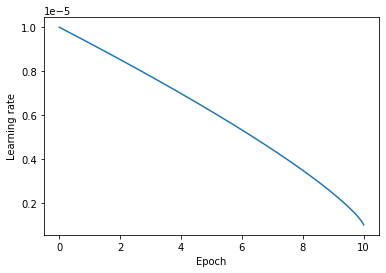

In [40]:
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate,
        epochs,
        end_learning_rate,
        power=0.8)

x = tf.linspace(0, epochs, 1001)
y = [learning_rate_fn(xi) for xi in x]
plt.plot(x,y)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

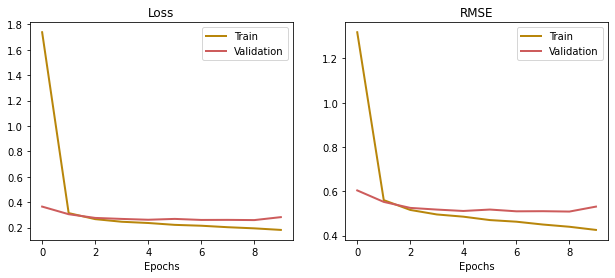

In [39]:
if developing:
    # grab history
    history = hist.history

    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1, 3, 1)

    plt.plot(history['loss'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_loss'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.5,0.7)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('Loss');

    ax = fig.add_subplot(1, 3, 2)

    plt.plot(history['root_mean_squared_error'], lw=2, color='darkgoldenrod')
    plt.plot(history['val_root_mean_squared_error'], lw=2, color='indianred')
    plt.legend(['Train', 'Validation'], fontsize=10)
    #plt.ylim(0.5,0.7)
    ax.set_xlabel('Epochs', size=10)
    ax.set_title('RMSE');

In [41]:
test_predictions = model.predict(x={
                'tokens': test_data_comp_input_ids,
                'attention_mask': test_data_comp_attention_mask,
            })


test_predictions = pd.DataFrame(test_predictions)
test_from_comp['cohesion'] = test_predictions[0]
test_from_comp['syntax'] = test_predictions[1]
test_from_comp['vocabulary'] = test_predictions[2]
test_from_comp['phraseology'] = test_predictions[3]
test_from_comp['grammar'] = test_predictions[4]
test_from_comp['conventions'] = test_predictions[5]
test_from_comp

NameError: name 'test_data_comp_input_ids' is not defined

In [31]:
res = test_from_comp.drop("full_text",axis=1)
res.to_csv("/kaggle/working/submission.csv",index=False)